## Machine Learning for Medical Image Reconstruction

# Image Reconstruction Lab

## Christoph Kolbitsch, PTB Berlin, Germany


### Overview

In the previous lectures we discussed several approaches of how deep learning can be used for image reconstruction. 
In this image reconstruction lab we are going to implement one of these approaches. 

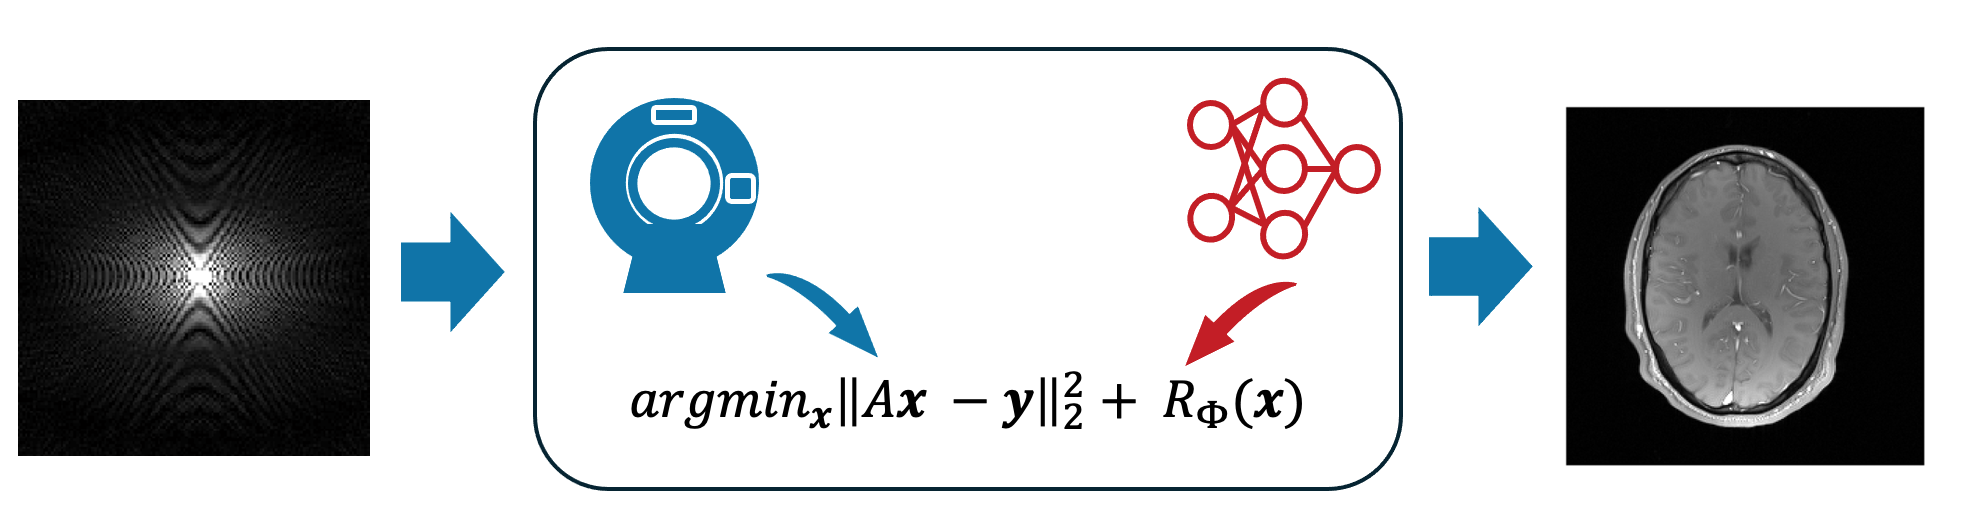

We are going to learn:
- how to read in MR raw data
- understand the structure and parameters of MR raw data
- create an acquisition model $A$ describing our data acquisition
- carry out a standard conjugate-gradient based iterative reconstruction
- extend this reconstruction by including a neural network
- evaluate image quality

### Important

If you are running this notebook on binder then everything you need will already be preinstalled. If you are running it
on your local computer or in Google colab then please ensure you have got MRpro (https://github.com/PTB-MR/mrpro) 
installed. For Google colab simply run 
```!pip install mrpro```.

### Read in MR raw data

The data which we acquired in the last lecture with the open-source scanner is saved in an open-source vendor-agnostic
raw data format called MRD (MR raw data). A MRD-file contains the acquired k-space data but also information about the
dimensions of the k-space, where in k-space the data has been acquired and what the dimension and resolution of the 
final reconstructed image should be like. Lucky for us, the MRpro package does most of the work for us and therefore 
reading in a MRD file is as simple as:

In [ ]:
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryCartesian
kdata = KData.from_file(data_file.name, KTrajectoryCartesian())

Apart from the filename we only had to provide information about the type of trajectory used to obtain the raw data. We
know that we used a Cartesian sampling scheme and so we defined the trajectory with ```KTrajectoryCartesian()```. 

### Structure of MR raw data

Now we can have a look at the kdata object and at some header parameters

In [ ]:
print(kdata)

In [ ]:
print(kdata.header.h1_freq)

### Acquisition model

In the lectures we have always used a simple $A$ to describe the acquisition model without discussing how this is 
actually created. The acquisition model $A$ describe what happens during the acquisition process. This includes the 
Fourier encoding of the MR signal and the k-space sampling. All of the necessary information to create this linear model 
is part of the k-space data. So we can simply create $A$ by 

In [ ]:
from mrpro.operators import FourierOp
acquisition_model = FourierOp.from_kdata(kdata)

Now we can use the adjoint of the acquisition model to obtain a first reconstruction of our image

In [ ]:
img = acquisition_model.H(kdata.data)

from matplotlib.pyplot import plt 
plt.figure() 
plt.imshow(img.abs()[0,0,0,...])